# Fast CNN #

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.fft

### Preprocess Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train =True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train =False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 62638887.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Define the classes

In [4]:
classes = ('plane','car','bird','cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data Visualization

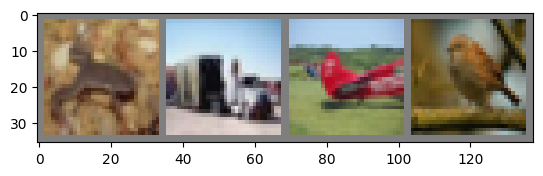

 frog truck plane  bird


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

data_iter = iter(trainloader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

### Initialize CNN


In [6]:
class CIFARmodel(nn.Module):
    def __init__(self):
        super(CIFARmodel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fft_conv = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(64, 64, 5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = F.relu(self.fft_convolution(x, self.fft_conv.weight, self.fft_conv.bias))

        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def fft_convolution(self, x, weight, bias=None):
        batch_size, in_channels, height, width = x.size()
        out_channels, _, kernel_height, kernel_width = weight.size()

        x_fft = torch.fft.rfftn(x, s=(height, width), dim=(-2, -1))
        weight_fft = torch.fft.rfftn(weight, s=(height, width), dim=(-2, -1))

        result_fft = x_fft.unsqueeze(1) * weight_fft.unsqueeze(0)

        result_fft = result_fft.sum(dim=2)

        result = torch.fft.irfftn(result_fft, s=(height, width), dim=(-2, -1))

        result = result[..., :height, :width]

        if bias is not None:
            result += bias.view(1, -1, 1, 1)

        return result

model = CIFARmodel()
print(model)

CIFARmodel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fft_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 5, 5])
torch.Size([64])
torch.Size([128, 4096])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


### Initialize Loss and Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [9]:
dataiter = iter(trainloader)
images, label = next(dataiter)
print(images)

tensor([[[[-0.6471, -0.5686, -0.6235,  ...,  0.5451,  0.5137,  0.5137],
          [-0.6471, -0.5843, -0.6784,  ...,  0.3490,  0.3333,  0.2863],
          [-0.6471, -0.5922, -0.7725,  ...,  0.1451,  0.1373,  0.1059],
          ...,
          [-0.2627, -0.2078, -0.1451,  ..., -0.0196, -0.0275, -0.0667],
          [-0.2706, -0.2314, -0.3333,  ..., -0.0667, -0.1451, -0.0275],
          [-0.4275, -0.4039, -0.3569,  ..., -0.1451, -0.0902,  0.0118]],

         [[-0.5686, -0.5137, -0.5843,  ...,  0.5765,  0.5451,  0.5451],
          [-0.5686, -0.5216, -0.6392,  ...,  0.3804,  0.3647,  0.3176],
          [-0.5686, -0.5294, -0.7333,  ...,  0.1765,  0.1686,  0.1373],
          ...,
          [-0.1922, -0.1373, -0.0745,  ...,  0.0431,  0.0353, -0.0039],
          [-0.2000, -0.1608, -0.2627,  ..., -0.0039, -0.0824,  0.0353],
          [-0.3569, -0.3333, -0.2863,  ..., -0.0824, -0.0275,  0.0745]],

         [[-0.5059, -0.4667, -0.5529,  ...,  0.6471,  0.6235,  0.6157],
          [-0.5059, -0.4745, -

### Train Dataset

[1,     1] loss: 0.002
[1,  1001] loss: 2.295
[1,  2001] loss: 2.084
[1,  3001] loss: 1.886
[1,  4001] loss: 1.727
[1,  5001] loss: 1.624
[1,  6001] loss: 1.558
[1,  7001] loss: 1.491
[1,  8001] loss: 1.408
[1,  9001] loss: 1.403
[1, 10001] loss: 1.322
[1, 11001] loss: 1.293
[1, 12001] loss: 1.236
[2,     1] loss: 0.001
[2,  1001] loss: 1.193
[2,  2001] loss: 1.191
[2,  3001] loss: 1.138
[2,  4001] loss: 1.120
[2,  5001] loss: 1.070
[2,  6001] loss: 1.074
[2,  7001] loss: 1.046
[2,  8001] loss: 1.038
[2,  9001] loss: 1.020
[2, 10001] loss: 0.985
[2, 11001] loss: 0.999
[2, 12001] loss: 0.989
[3,     1] loss: 0.000
[3,  1001] loss: 0.878
[3,  2001] loss: 0.904
[3,  3001] loss: 0.844
[3,  4001] loss: 0.859
[3,  5001] loss: 0.845
[3,  6001] loss: 0.839
[3,  7001] loss: 0.816
[3,  8001] loss: 0.842
[3,  9001] loss: 0.834
[3, 10001] loss: 0.822
[3, 11001] loss: 0.818
[3, 12001] loss: 0.820
[4,     1] loss: 0.001
[4,  1001] loss: 0.677
[4,  2001] loss: 0.690
[4,  3001] loss: 0.694
[4,  4001] 

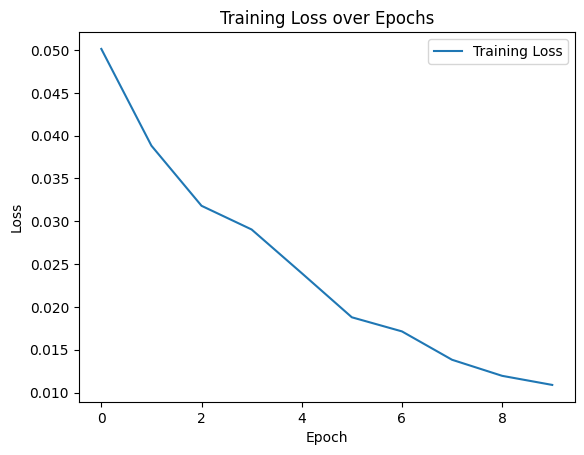

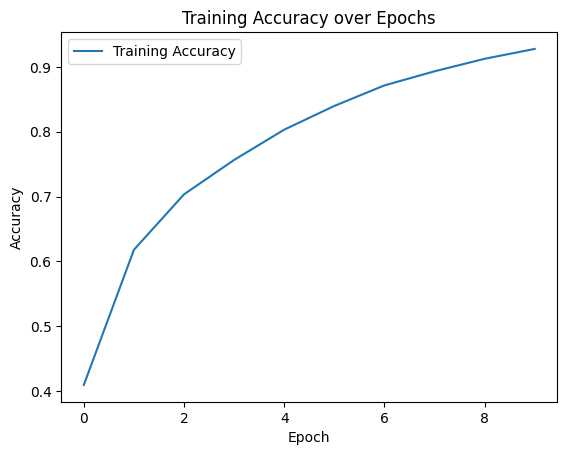

In [10]:
total_epochs = 10
loss_values = []
accuracy_values = []

for epoch in range(total_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        if i % 1000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

print("Training finished")

# Plotting loss
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

In [11]:
PATH = './cifar_model'
torch.save(model.state_dict(), PATH)

### Test Dataset

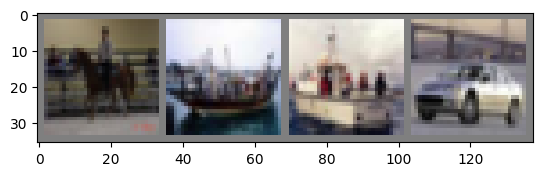

Original Label:  horse  ship  ship   car


In [12]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print("Original Label: ",' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [13]:
model = CIFARmodel()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
output = model(images)

In [15]:
_, predicted = torch.max(output,1)
print('predicted:',' '.join("%5s" %classes[labels[j]]for j in range(4)))

predicted: horse  ship  ship   car


### Accuracy

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print('Accuracy of the model on test set:', (correct*100)/total)

Accuracy of the model on test set: 72.68


### Class Accuracies

In [17]:
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (classes[i], accuracy))
    else:
        print('Accuracy of %5s : N/A (no samples in test set)' % classes[i])


Accuracy of plane : 70 %
Accuracy of   car : 82 %
Accuracy of  bird : 64 %
Accuracy of   cat : 53 %
Accuracy of  deer : 70 %
Accuracy of   dog : 60 %
Accuracy of  frog : 78 %
Accuracy of horse : 75 %
Accuracy of  ship : 87 %
Accuracy of truck : 83 %
